In [3]:
from app.features.manual.models.model import create_openai_model
from app.features.manual.nodes.nodes import (
        generate_history_base_answer,
        genesis_check_and_query_split,
        generate_vector_search_base_answer,
        grade_hallucination,
        grade_hallucination_conditional,
        calculate_score,
        query_rewrite,
        history_base_answer_check_conditional,
        genesis_check_conditional,
        calculate_score_conditional
)
from langgraph.graph import StateGraph, START, END
from app.features.manual.utils.types import State

from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph


def run_manual_chatbot() :
    """
        RAG 파이프라인을 실행합니다.

        Args:
            user_input (str): 사용자 입력 질문.
            conversation_history (list): 이전 대화 기록 (선택적).

        Returns:
            str: RAG를 통해 생성된 최종 답변.
    """
    graph_builder = StateGraph(State)
    graph_builder.add_node("generate_history_base_answer", generate_history_base_answer)
    graph_builder.add_node("genesis_check", genesis_check_and_query_split)
    graph_builder.add_node("generate_vector_search_base_answer", generate_vector_search_base_answer)
    graph_builder.add_node("grade_hallucination", grade_hallucination)
    graph_builder.add_node("calculate_score", calculate_score)
    graph_builder.add_node("query_rewrite", query_rewrite)

    graph_builder.add_edge(START, "genesis_check")

    graph_builder.add_edge('query_rewrite', "generate_vector_search_base_answer")
    graph_builder.add_edge('generate_vector_search_base_answer', "grade_hallucination")
    graph_builder.add_edge('query_rewrite', "generate_vector_search_base_answer")

    graph_builder.add_conditional_edges(
        'generate_history_base_answer',
        history_base_answer_check_conditional,
        path_map={"search": "generate_vector_search_base_answer", END: END},
    )

    graph_builder.add_conditional_edges(
        'genesis_check',
        genesis_check_conditional,
        path_map={"write": "generate_history_base_answer", END: END},
    )

    graph_builder.add_conditional_edges(
        'grade_hallucination',
        grade_hallucination_conditional,
        path_map={"rewrite": "query_rewrite", 'calculate': "calculate_score"},
    )

    graph_builder.add_conditional_edges(
        "calculate_score",
        calculate_score_conditional,
        path_map={"rewrite": "query_rewrite", END: END},
    )
    graph = graph_builder.compile()


    return graph

graph = run_manual_chatbot()

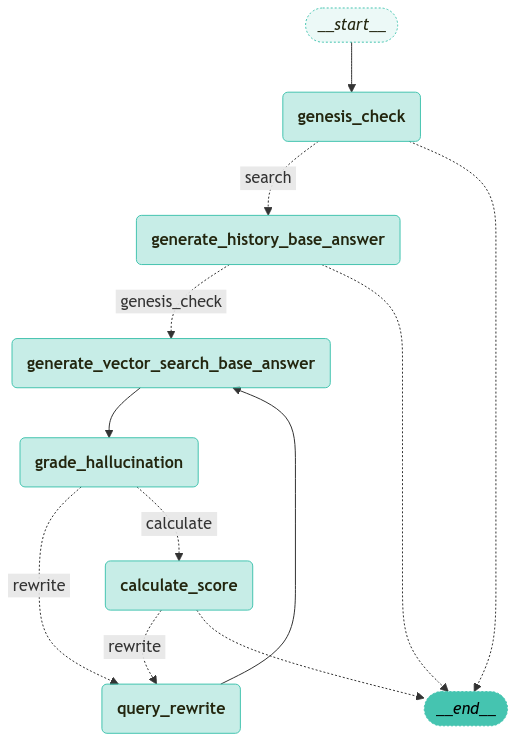

In [4]:
from langchain_teddynote.graphs import visualize_graph

# 그래프 시각화
visualize_graph(graph)

In [ ]:
graph.invok